# Load Libraries and Model

In [30]:
import sys
path = '/home/atom/Dropbox/Skule/EECE571F/Project/research-contributions/UNETR/BTCV/networks' # '/Users/Atom/Dropbox/Skule/EECE571F/Project/research-contributions/UNETR/BTCV/networks'
sys.path.append(path)

In [31]:
import glob

from tqdm import trange
import nibabel as nib
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
from skimage.transform import resize
import matplotlib.pyplot as plt

from unetr import UNETR
# from self_attention_cv.Transformer3Dsegmentation.tranf3Dseg import Transformer3dSeg
# from self_attention_cv.transunet import TransUnet
# from self_attention_cv import TransformerEncoder
# from self_attention_cv import ViT, ResNet50ViT

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='bool')[y.astype(np.int16)]

In [4]:
def generate_brats_batch(prefix, 
                         contrasts, 
                         batch_size=32, 
                         tumour='*', 
                         patient_ids='*',
                         resample_size=(None, None, None),
                         augment_size=None,
                         infinite=True):
    """
    Generate arrays for each batch, for x (data) and y (labels), where the contrast is treated like a colour channel.
    
    Example:
    x_batch shape: (32, 240, 240, 155, 4)
    y_batch shape: (32, 240, 240, 155)
    
    augment_size must be less than or equal to the batch_size, if None will not augment.
    
    """
    file_pattern = '{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{patient_id}/{patient_id}_{contrast}.nii.gz'
    while True:
        n_classes = 4

        # get list of filenames for every contrast available
        keys = dict(prefix=prefix, tumour=tumour)
        filenames_by_contrast = {}
        for contrast in contrasts:
            filenames_by_contrast[contrast] = glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_ids, **keys)) if patient_ids == '*' else []
            if patient_ids != '*':
                contrast_files = []
                for patient_id in patient_ids:
                    contrast_files.extend(glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_id, **keys)))
                filenames_by_contrast[contrast] = contrast_files

        # get the shape of one 3D volume and initialize the batch lists
        arbitrary_contrast = contrasts[0]
        shape = nib.load(filenames_by_contrast[arbitrary_contrast][0]).get_fdata().shape if resample_size == (None, None, None) else resample_size

        # initialize empty array of batches
        x_batch = np.empty((batch_size, ) + shape + (len(contrasts), )) #, dtype=np.int32)
        y_batch = np.empty((batch_size, ) + shape + (n_classes,)) #, dtype=np.int32)
        num_images = len(filenames_by_contrast[arbitrary_contrast])
        np.random.shuffle(filenames_by_contrast[arbitrary_contrast])
        for bindex in trange(0, num_images, batch_size):
            filenames = filenames_by_contrast[arbitrary_contrast][bindex:bindex + batch_size]
            for findex, filename in enumerate(filenames):
                for cindex, contrast in enumerate(contrasts):

                    # load raw image batches and normalize the pixels
                    tmp_img = nib.load(filename.replace(arbitrary_contrast, contrast)).get_fdata()
                    if resample_size != (None, None, None):
                        tmp_img = resize(tmp_img, resample_size, mode='edge')
                    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)
                    x_batch[findex, ..., cindex] = tmp_img

                    # load mask batches and change to categorical
                    tmp_mask = nib.load(filename.replace(arbitrary_contrast, 'seg')).get_fdata()
                    tmp_mask[tmp_mask==4] = 3
                    tmp_mask = to_categorical(tmp_mask, num_classes=4)
                    if resample_size != (None, None, None):
                        tmp_mask = resize(tmp_mask, resample_size, mode='edge')
                    y_batch[findex] = tmp_mask

            if bindex + batch_size > num_images:
                x_batch, y_batch = x_batch[:num_images - bindex], y_batch[:num_images - bindex]
            if augment_size is not None:
                # x_aug, y_aug = augment(x_batch, y_batch, augment_size)
                x_aug = None
                y_aug = None
                yield np.append(x_batch, x_aug), np.append(y_batch, y_aug)
            else:
                yield x_batch, y_batch
        if not infinite:
            break

In [5]:
# prefix = '/home/atom/Documents/datasets/brats' # Adam's Station
prefix = '/Users/Atom/Documents/datasets/brats'
trained_model = 'unetr_models/model_20220418_212816_45'

In [6]:
brats_classes = 4
brats_contrasts = 4
brats_x = 80 # 240
brats_y = 80 # 240
brats_z = 80 # 155
resampled_shape = (brats_x, brats_y, brats_z)

patch_size = 16
feature_size = 20
embedding_size = 768 # 1536
msa_heads = 6 # 12
mlp_size = 1024 # 2048

dropout = 0.10
max_epochs = 50
learning_rate = 0.0005

In [7]:
class OURUNETR(UNETR):
    
    @property
    def patch_size(self):
        return (patch_size, patch_size, patch_size)
    
    @patch_size.setter
    def patch_size(self, value):
        pass

In [8]:
model = OURUNETR(
    in_channels=brats_contrasts,
    out_channels=brats_classes,
    img_size=(brats_x, brats_y, brats_z),
    feature_size=feature_size,
    hidden_size=embedding_size,
    mlp_dim=mlp_size,
    num_heads=msa_heads,
    pos_embed='perceptron',
    norm_name='instance',
    conv_block=True,
    res_block=True,
    dropout_rate=dropout)

In [9]:
model.load_state_dict(torch.load(f'{prefix}/{trained_model}', map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
model

OURUNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=16384, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=768, bias=True)
          (fn): GELU()
          (drop1): Dropout(p=0.1, inplace=False)
          (drop2): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (drop_output): Dropout(p=0.1, inplace=False)
        

# Load sample data

In [50]:
test_id = 'Brats18_CBICA_APR_1' # 'Brats18_TCIA01_147_1'
tumour = 'HGG'
contrast = 'flair'
contrasts = ['t1ce', 'flair', 't2', 't1']
filename = f'{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{test_id}/{test_id}_{contrast}.nii.gz'

In [51]:
nii_img  = nib.load(filename)
nii_data = nii_img.get_fdata()

In [52]:
nii_data.shape

(240, 240, 155)

In [53]:
model.eval()
with torch.no_grad():
    for img, mask in generate_brats_batch(prefix, contrasts, batch_size=1, patient_ids=[test_id], infinite=False, resample_size=resampled_shape):
        # img (1, 240, 240, 155, 4) -> (1, 4, 240, 240, 155)
        img, mask = np.rollaxis(img, -1, 1), np.rollaxis(mask, -1, 1)
        
        output = torch.softmax(model(torch.FloatTensor(img)), 1)
        
        # output = torch.argmax(to_categorical_tensor(output,4), 1)
        # print("output shape ", output.shape)
        # print(f'output max {output.max()} and min {output.min()}')
        # test = to_categorical_tf(torch.argmax(output,dim=1),4)
                    
        # full_output[..., i:i+block_side, j:j+block_side, k:k+block_side] = output # np.repeat(np.repeat(np.repeat(output, patch_side, axis=-3), patch_side, axis=-2), patch_side, axis=-1)
        # print("output shape: ", full_output.shape)
                    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


In [54]:
_, ground_truth = next(generate_brats_batch(prefix, contrasts, batch_size=1, patient_ids=[test_id], infinite=False))

  0%|                                                                                                       | 0/1 [00:01<?, ?it/s]


# Visualize

In [82]:
slice_percent = 0.59

In [83]:
int(round(slice_percent * output.shape[-1]))

47

In [84]:
from tensorflow.keras.metrics import IoU
predict_mask = output.cpu().detach().numpy()
predict_mask = np.argmax(predict_mask, axis=1)[0,:,:,:]
ground_truth_mask = np.argmax(mask, axis=1)[0,:,:,:]

n_classes = 4
iou_list = []
for i in range(n_classes):
    IOU = IoU(num_classes=n_classes, target_class_ids=[i])
    IOU.update_state(predict_mask, ground_truth_mask)
    iou_list.append(IOU.result().numpy())

print(iou_list)

[0.9983779, 0.7320725, 0.62788993, 0.68501526]


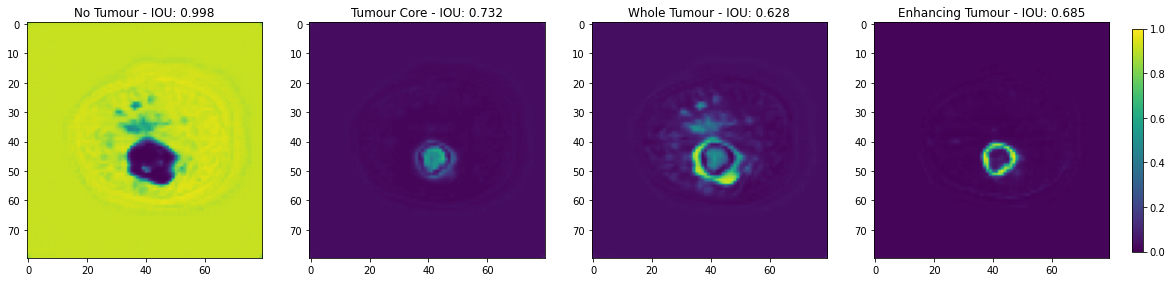

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
titles = ['No Tumour', 'Tumour Core', 'Whole Tumour', 'Enhancing Tumour']
for i in range(brats_classes):
    im = axs[i].imshow(output[0, i, :, :, int(round(slice_percent * output.shape[-1]))], vmin=0, vmax=1);
    axs[i].set_title(f'{titles[i]} - IOU: {iou_list[i]:.3g}')
fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.01, pad=0.02)
# plt.savefig(f'../results/unetr/{test_id}_predicted_probs.png')

In [86]:
# np.savez('../results/unetr/pred_mask.npz', pred_mask=output.argmax(axis=1)[0, :, :, int(round(slice_percent * output.shape[-1]))])

Text(0.5, 1.0, 'Original Ground Truth Segmentation')

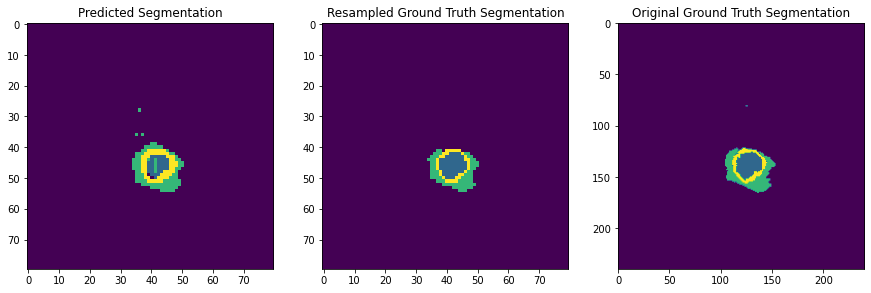

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(output.argmax(axis=1)[0, :, :, int(round(slice_percent * output.shape[-1]))]);
axs[0].set_title('Predicted Segmentation')
axs[1].imshow(mask.argmax(axis=1)[0, :, :, int(round(slice_percent * mask.shape[-1]))]);
axs[1].set_title('Resampled Ground Truth Segmentation')
axs[2].imshow(ground_truth.argmax(axis=-1)[0, :, :, int(round(slice_percent * ground_truth.shape[-2]))]);
axs[2].set_title('Original Ground Truth Segmentation')
# add legend
# plt.savefig(f'../results/unetr/{test_id}_predicted_vs_gt.png')

In [27]:
ground_truth.shape

(1, 240, 240, 155, 4)

In [29]:
import napari
viewer = napari.view_image(output[0, 1].detach().numpy(), name="tumour core prediction probabilities")
for i in range(len(contrasts)):
    viewer.add_image(img[0, i, ...], name=test_id + '' + contrasts[i])

gt_layer = viewer.add_labels(mask.argmax(axis=1)[0], name="ground truth")
pred_layer = viewer.add_labels(output.argmax(axis=1)[0].detach().numpy(), name="predicted classes")

In [3]:
# try to quantify attention of the UNETR